# Learning Notebooks...
https://github.com/Azure/MachineLearningNotebooks

# <center>What is the goal?</center>

Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

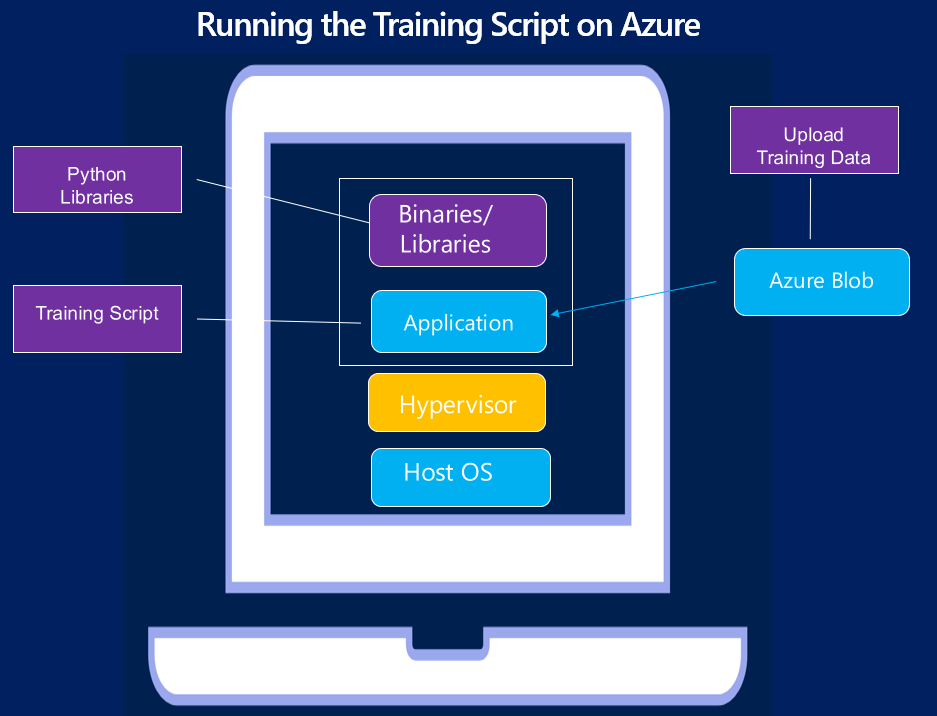

# Setting things up...

In [3]:
import azureml.core
print(azureml.core.VERSION)

from azureml.core import Workspace

1.0.74


## Define some variables...

In [6]:
my_subscriptionid = '050aedf0-1ce2-495f-a726-be8756f5ab18'
resource_group = 'rg_bpcdp100amlsws'

print(my_subscriptionid)
print(resource_group)

050aedf0-1ce2-495f-a726-be8756f5ab18
rg_bpcdp100amlsws


## You can create an AML workspace in Python but we don't need to.

In [ ]:
'''
import azureml.core
print(azureml.core.VERSION)

from azureml.core import Workspace
ws = Workspace.create(name='bpcdp100ws',
            subscription_id=my_subscriptionid, 
            resource_group=resource_group,
            create_resource_group = True,
            location='east-us2'
            )
'''            

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/tutorials/img-classification-part1-training.png)

## Workspace Properties from Above:

Name | Description
---- | -----------
name            | A name you chose to call the workspace.  We'll use the value aready in the code.
subscription_id | The id of the subscription the workspace will be assigned to.  You can get this from the Azure portal.
resource_group  | A name you want all the Azure resourced creates for the workspace to be associated with.  Makes rsource management easier.
location | Azure data center location closest to you that support creation of AMLS workspaces.  

## Other ways to create an AML service workspace:

### - Using the Azure Portal
### - ARM Template

See link for more information: https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-manage-workspace

________

### If the AML service workspace is already created, just connect to it...

In [7]:
# Method 2: Using the get() method...

from azureml.core import Workspace

ws = Workspace.get(name='bpcdp100amlsws',
                   subscription_id=my_subscriptionid,
                   resource_group=resource_group
                  )

print(ws.name, ws.location, ws.resource_group, ws.location, sep='\t')

bpcdp100amlsws	centralus	rg_bpcdp100amlsws	centralus


In [ ]:
print('Ok')

# Train and Deploy a Model on Azure Machine Learning service.

In this lab, you train the classifcation machine learning model on remote compute resources. You'll use the training and deployment workflow for Azure Machine Learning service (preview) in a Python Jupyter notebook.  

Learn how to:

> * Set up your development environment
> * Access and examine the data
> * Train a simple classification model on a remote cluster
> * Review training results, find and register the best model

## Set up your development environment

All the setup for your development work can be accomplished in a Python notebook.  Setup includes:

* Create an Experiment in an existing Workspace.
* Configure AutoML using AutoMLConfig.
* Importing Python packages
* Connecting to a workspace to enable communication between your local computer and remote resources
* Creating an experiment to track all your runs
* Creating a remote compute target to use for training

### Import packages

Import Python packages you need in this session. Also display the Azure Machine Learning SDK version.

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import azureml.core
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.74


## To make reconnecting to this workspace in future notebooks easier, save the configuration setting using the code in the cell below.

In [6]:
# Create the configuration file.

ws.write_config()
print('Configuration saved.')

Configuration saved.


In [7]:
ws

Workspace.create(name='bpcdp100amlsws', subscription_id='050aedf0-1ce2-495f-a726-be8756f5ab18', resource_group='rg_bpcdp100amlsws')

In [8]:
# Note a file was written to the current working folder...
# -a  = show hidden files
# -Lr = include subfolders

%ls -a -Lr

set_subscriptionid.ipynb*    bwmodel.yml*
score.py*                    birthweightemodel.pkl*
Model Interpretation.ipynb*  .azureml/
.ipynb_checkpoints/          05 - Optimizing Model Training.ipynb*
dp100/                       04- Compute Contexts.ipynb*
download_explanation/        03 - From Data to Model.ipynb*
diabetes_training/           02 - Deploy and Use a Model.ipynb*
diabetes_train_and_explain/  01 - Train a Model.ipynb*
data/                        ../
.config/                     ./


### Create experiment

Create an experiment to track the runs in your workspace. A workspace can have muliple experiments. 

In [9]:
experiment_name = 'dp100class'

from azureml.core import Experiment

exp = Experiment(workspace=ws, name=experiment_name)

print('Experiment created.')

Experiment created.


### Create or Attach existing compute resource
By using Azure Machine Learning Compute, a managed service, data scientists can train machine learning models on clusters of Azure virtual machines. Examples include VMs with GPU support. In this tutorial, you create Azure Machine Learning Compute as your training environment. The code below creates the compute clusters for you if they don't already exist in your workspace.

**Creation of compute takes approximately 5 minutes.** If the AmlCompute with that name is already in your workspace the code will skip the creation process.

### See this link for full details about defining the compute for AMLS: https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-set-up-training-targets

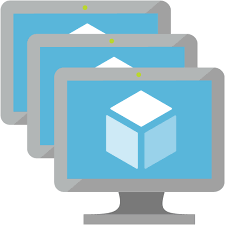

# Training compute - this is where you will train your model

## Note: You can also create the compute resources in the Azure Portal.


In [10]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
import os

# Set compute properties...
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "dp100training")    # Cluster name - length under 16 characters
compute_min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)     # minimum number of nodes 
compute_max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 4)     # maximum number of nodes

# This example uses CPU VM. For using GPU VM, set SKU to STANDARD_NC6
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "STANDARD_D3_V2")


if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print('found compute target. just use it. ' + compute_name)
else:
    print('creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size,
                                                                min_nodes = compute_min_nodes, 
                                                                max_nodes = compute_max_nodes)

    # create the cluster
    compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)
    
    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)
    
     # For a more detailed view of current AmlCompute status, use get_status()
    print(compute_target.get_status().serialize())

found compute target. just use it. dp100training


You now have the necessary packages and compute resources to train a model in the cloud. 

## Verify you have the data

You already explored the data in the last lab.  You need to copy the data into the cloud so it can be accessed by your cloud training environment.  We saved the model training data to a csv file so all we have to do is load it.

In [11]:
import pandas as pd

df_birthwt = pd.read_csv(r'./data/birthwt.csv')
print('Done')

Done


### Display a few rows of data to make sure the load worked.

In [12]:
df_birthwt.head()

id  low  age  lwt  race  smoke  ptl  ht  ui  ftv   bwt
0  85    0   19  182     2      0    0   0   1    0  2523
1  86    0   33  155     3      0    0   0   0    3  2551
2  87    0   20  105     1      1    0   0   0    1  2557
3  88    0   21  108     1      1    0   0   1    2  2594
4  89    0   18  107     1      1    0   0   1    0  2600

In [13]:
df_lbw_model = pd.read_csv(r'./data/birthwt.csv')
df_y = df_lbw_model['low']
df_y.head()

0    0
1    0
2    0
3    0
4    0
Name: low, dtype: int64

Now you have an idea of what these images look like and the expected prediction outcome.

### Upload data to the cloud

Now make the data accessible remotely by uploading that data from your local machine into Azure so it can be accessed for remote training. The datastore is a convenient construct associated with your workspace for you to upload/download data, and interact with it from your remote compute targets. It is backed by Azure blob storage account.

The data file is uploaded into a directory named `dp100lab` at the root of the datastore.

# <center>Warning!!!</center>
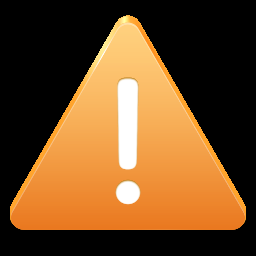


# Important:  The AML service SDK will automatically uploads everything in the folder you specify or the default folder.  This can cause problems including hitting the Azure file upload limit.  Moving the data to a separate folder solves this issue.


In [14]:
import urllib.request

data_folder = os.getcwd() + '/data'
print(data_folder)

os.listdir(data_folder)

/mnt/azmnt/code/Users/data


['birthwt.csv', 'diabetes.csv']

In [15]:
ds = ws.get_default_datastore()
print(ds)

In [16]:
print(ds.datastore_type, ds.account_name, ds.container_name)

ds.upload(src_dir=data_folder, target_path='dp100', overwrite=True, show_progress=True)

AzureBlob bpcdp100amlsws9506902906 azureml-blobstore-828d7ff8-19fd-4bea-8401-089509e53408
Uploading an estimated of 2 files
Uploading /mnt/azmnt/code/Users/data/birthwt.csv
Uploading /mnt/azmnt/code/Users/data/diabetes.csv
Uploaded /mnt/azmnt/code/Users/data/birthwt.csv, 1 files out of an estimated total of 2
Uploaded /mnt/azmnt/code/Users/data/diabetes.csv, 2 files out of an estimated total of 2
Uploaded 2 files


$AZUREML_DATAREFERENCE_10be4923b94b4326957301ca0fd43817

In [17]:
#  We can see what built-in datastores are available with this code below...
datastores = ws.datastores
for name, ds in datastores.items():
    print(name, ds.datastore_type)

workspacefilestore AzureFile
workspaceblobstore AzureBlob


## Test our training script without AMLS

In [18]:
from sklearn.model_selection import train_test_split
from sklearn import tree
import numpy as np

# Get the data...
filepath = os.path.join(data_folder, 'birthwt.csv')
df_lbw_model = pd.read_csv(filepath)
df_y = df_lbw_model['low']
df_lbw_model = df_lbw_model.drop(['low','bwt'], axis=1)

max_depth = 12

X_train, X_test, y_train, y_test = train_test_split(df_lbw_model, df_y, test_size=0.3)

X = X_train
Y = y_train
clf = tree.DecisionTreeClassifier(max_depth = max_depth)
clf = clf.fit(X, Y)
clf

# Predict using the test data...
print('Running the test dataset through...')
y_predtest = clf.predict(X_test)
print('Test dataset scored.')

# calculate accuracy on the prediction
acc = np.average(y_predtest == y_test)
print('Accuracy is', acc)

Running the test dataset through...
Test dataset scored.
Accuracy is 1.0


In [19]:
print(y_predtest[0:5])
print(y_test[0:5])

[0 0 0 1 1]
26     0
56     0
37     0
153    1
151    1
Name: low, dtype: int64


## Train on a remote cluster

For this task, submit the job to the remote training cluster you set up earlier.  To submit a job you:
* Create a directory
* Create a training script
* Create an estimator object
* Submit the job 

### Create a directory

Create a directory to deliver the necessary code from your computer to the remote resource.


### Create a training script

To submit the job to the cluster, first create a training script. Run the following code to create the training script called `train.py` in the directory you just created. 

In [20]:
import os
script_folder = os.path.join(os.getcwd(), "dp100")
os.makedirs(script_folder, exist_ok=True)

In [21]:
script_folder

'/mnt/azmnt/code/Users/dp100'

## About training scripts...

#### To train a model in an Azure container, we need to get the model training script to the container. We start by saving the model training script to a Python script file, i.e. .py.  This will be uploaded to the Azure container later.  We don't need any exploratory code in this script, just what is needed to train the model.

# Clasiification training script below.

# Notice we are writing the cell contents to the script folder we created.

In [22]:
%%writefile $script_folder/train.py

import argparse
import os

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib

from azureml.core import Run
print('Libraries Imported')

# 
# --------------------------------------------------------------
# ***  Azure Machine Learning service specfic code starts... ***
# --------------------------------------------------------------
#

# let user feed in 2 parameters, the location of the data files (from datastore), and the regularization rate of the logistic regression model
parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--maxdepth', type=float, dest='max_depth', default=14, help='max_depth')
args = parser.parse_args()

data_folder = args.data_folder
max_depth = args.max_depth

print('Data folder:', data_folder)

# get hold of the current run
run = Run.get_context()


#
# --------------------------------------------------------------
# ***  Azure Machine Learning service specfic code ends. ***
# --------------------------------------------------------------
#

# ************************************************************
#     *******  Model Training Code starts here ********
# ************************************************************

from sklearn.model_selection import train_test_split
from sklearn import tree

# Get the data...
filepath = os.path.join(data_folder, 'birthwt.csv')
df_lbw_model = pd.read_csv(filepath)
df_y = df_lbw_model['low']
df_lbw_model = df_lbw_model.drop(['low','bwt'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_lbw_model, df_y.astype('category'), test_size=0.3)

X = X_train
Y = y_train
clf = tree.DecisionTreeClassifier(max_depth = max_depth)
clf = clf.fit(X, Y)
clf

# Predict using the test data...
print('Running the test dataset through...')
y_predtest = clf.predict(X_test)
print('Test dataset scored.')

# calculate accuracy on the prediction
acc = np.average(y_predtest == y_test)
print('Accuracy is', acc)

#     *******  Model Training Code end here ********

#
# --------------------------------------------------------------
# ***  Azure Machine Learning service specfic code starts... ***
# --------------------------------------------------------------
#

run.log('data_dir', data_folder)
run.log('accuracy', np.float(acc))

os.makedirs('outputs', exist_ok=True)

# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=clf, filename='outputs/birthweightemodel.pkl')

#
# --------------------------------------------------------------
# ***    Azure Machine Learning service specfic code ends. ***
# --------------------------------------------------------------
#

Overwriting /mnt/azmnt/code/Users/dp100/train.py


Notice how the script gets data and saves models:

+ The training script reads an argument to find the directory containing the data.  When you submit the job later, you point to the datastore for this argument:
`parser.add_argument('--data-folder', type=str, dest='data_folder', help='data directory mounting point')`


+ The training script saves your model into a directory named outputs. <br/>
`joblib.dump(value=clf, filename='outputs/biketypemodel.pkl')`<br/>
Anything written in this directory is automatically uploaded into your workspace. You'll access your model from this directory later in the tutorial.

### Create an estimator

An estimator object is used to submit the run.  Create your estimator by running the following code to define:

* The name of the estimator object, `est`
* The directory that contains your scripts. All the files in this directory are uploaded into the cluster nodes for execution. 
* The compute target.  In this case you will use the AmlCompute you created
* The training script name, train.py
* Parameters required from the training script 
* Python packages needed for training

In this tutorial, this target is AmlCompute. All files in the script folder are uploaded into the cluster nodes for execution. The data_folder is set to use the datastore (`ds.path('dp100lab').as_mount()`).

In [23]:
from azureml.train.estimator import Estimator

script_params = {
    '--data-folder': ds.path('dp100').as_mount(),
    '--maxdepth': 6 
}

est = Estimator(source_directory=script_folder,
                script_params=script_params,
                compute_target=compute_target,
                entry_script='train.py',
                conda_packages=['scikit-learn','pandas'])

print('Executed')

Executed


In [24]:
print(est)  # take a look at the est object...

In [25]:
script_folder

'/mnt/azmnt/code/Users/dp100'

### Submit the job to the cluster

Run the experiment by submitting the estimator object. And you can navigate to Azure portal to monitor the run.

In [27]:
run = exp.submit(config=est)
run
print('Complete')

Complete


Since the call is asynchronous, it returns a **Preparing** or **Running** state as soon as the job is started.

## Monitor a remote run

In total, the first run takes **approximately 10 minutes**. But for subsequent runs, as long as the dependencies (`conda_packages` parameter in the above estimator constructor) don't change, the same image is reused and hence the container start up time is much faster.

Here is what's happening while you wait:

- **Image creation**: A Docker image is created matching the Python environment specified by the estimator. The image is built and stored in the ACR (Azure Container Registry) associated with your workspace. Image creation and uploading takes **about 5 minutes**. 

  This stage happens once for each Python environment since the container is cached for subsequent runs.  During image creation, logs are streamed to the run history. You can monitor the image creation progress using these logs.

- **Scaling**: If the remote cluster requires more nodes to execute the run than currently available, additional nodes are added automatically. Scaling typically takes **about 5 minutes.**

- **Running**: In this stage, the necessary scripts and files are sent to the compute target, then data stores are mounted/copied, then the entry_script is run. While the job is running, stdout and the files in the ./logs directory are streamed to the run history. You can monitor the run's progress using these logs.

- **Post-Processing**: The ./outputs directory of the run is copied over to the run history in your workspace so you can access these results.


You can check the progress of a running job in multiple ways. This tutorial uses a Jupyter widget as well as a `wait_for_completion` method. 

### Jupyter widget

Watch the progress of the run with a Jupyter widget.  Like the run submission, the widget is asynchronous and provides live updates every 10-15 seconds until the job completes.

In [28]:
from azureml.widgets import RunDetails

print(RunDetails(run).show())

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

None


In [29]:
print('Ok')

Ok


In [29]:
#  If widgets is not installed, you can run the line below to install it.

#  !pip install --upgrade azureml.widgets[notebooks]

     |████████████████████████████████| 9.3MB 3.8MB/s 


By the way, if you need to cancel a run, you can follow [these instructions](https://aka.ms/aml-docs-cancel-run).

### Get log results upon completion

Model training happens in the background. You can use `wait_for_completion` to block and wait until the model has completed training before running more code. 

In [30]:
# specify show_output to True for a verbose log
run.wait_for_completion(show_output=False) 

{'runId': 'dp100class_1574006606_261ab0f8',
 'target': 'dp100training',
 'status': 'Completed',
 'startTimeUtc': '2019-11-17T16:08:46.268305Z',
 'endTimeUtc': '2019-11-17T16:11:18.917471Z',
 'properties': {'_azureml.ComputeTargetType': 'batchai',
  'ContentSnapshotId': '3644b8ea-88c3-44c1-89b1-ee6157a0d22c',
  'AzureML.DerivedImageName': 'azureml/azureml_fd0e07448b33ff52d674b873ca7dbcdd',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [],
 'runDefinition': {'script': 'train.py',
  'arguments': ['--data-folder',
   '$AZUREML_DATAREFERENCE_5846ff7988344c0f8939ed1f19bbef25',
   '--maxdepth',
   '6'],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'dp100training',
  'dataReferences': {'5846ff7988344c0f8939ed1f19bbef25': {'dataStoreName': 'workspaceblobstore',
    'mode': 'Mount',
    'pathOnDataStore': 'dp100',
    'pathOnCompute': None,
    'overwrite':

### Display run results

You now have a model trained on a remote cluster.  Retrieve all the metrics logged during the run, including the accuracy of the model:

In [31]:
print(run.get_metrics())

{'data_dir': '/mnt/batch/tasks/shared/LS_root/jobs/bpcdp100amlsws/azureml/dp100class_1574006606_261ab0f8/mounts/workspaceblobstore/dp100', 'accuracy': 0.9824561403508771}


In the next tutorial you will explore this model in more detail.

## Register model

The last step in the training script wrote the file `outputs/birthweighmodel.pkl` in a directory named `outputs` in the VM of the cluster where the job is executed. `outputs` is a special directory in that all content in this  directory is automatically uploaded to your workspace.  This content appears in the run record in the experiment under your workspace. Hence, the model file is now also available in your workspace.

You can see files associated with that run.

In [33]:
print(run.get_file_names())

['azureml-logs/55_azureml-execution-tvmps_f34ab893c242eb317c7cefa35d60e28807281722a2563f017456c9e4c2975ad4_d.txt', 'azureml-logs/65_job_prep-tvmps_f34ab893c242eb317c7cefa35d60e28807281722a2563f017456c9e4c2975ad4_d.txt', 'azureml-logs/70_driver_log.txt', 'azureml-logs/75_job_post-tvmps_f34ab893c242eb317c7cefa35d60e28807281722a2563f017456c9e4c2975ad4_d.txt', 'azureml-logs/process_info.json', 'azureml-logs/process_status.json', 'logs/azureml/153_azureml.log', 'logs/azureml/azureml.log', 'outputs/birthweightemodel.pkl']


Register the model in the workspace so that you (or other collaborators) can later query, examine, and deploy this model.

In [34]:
# register model 
model = run.register_model(model_name='bwmodel', model_path='outputs/birthweightemodel.pkl')
print('Model Name: ', model.name, '\t Model Version: ', model.version, '\t Model ID: ', model.id,  sep='\t')

Model Name: 	bwmodel		 Model Version: 	2		 Model ID: 	bwmodel:2


_______________________